In [2]:
%pip install torcheval

Note: you may need to restart the kernel to use updated packages.


#### Importing all Modules used

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torchvision
from torcheval.metrics import PeakSignalNoiseRatio, MeanSquaredError
from sklearn.kernel_approximation import RBFSampler
from sklearn import preprocessing

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Code for plotting the Images

In [4]:
def plot_images(images: list[torch.Tensor], titles: list[str], title=""):
    n = len(images)  # number of images
    fig = plt.figure(figsize=(6 * n, 8))
    gs = gridspec.GridSpec(1, n, width_ratios=[1] * n)

    axes = [plt.subplot(gs[i]) for i in range(n)]

    for i, (img, sup) in enumerate(zip(images, titles)):
        axes[i].imshow(img.cpu())
        axes[i].set_title(sup)
        axes[i].axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    plt.show()

#### Loading the Image file and normalising it

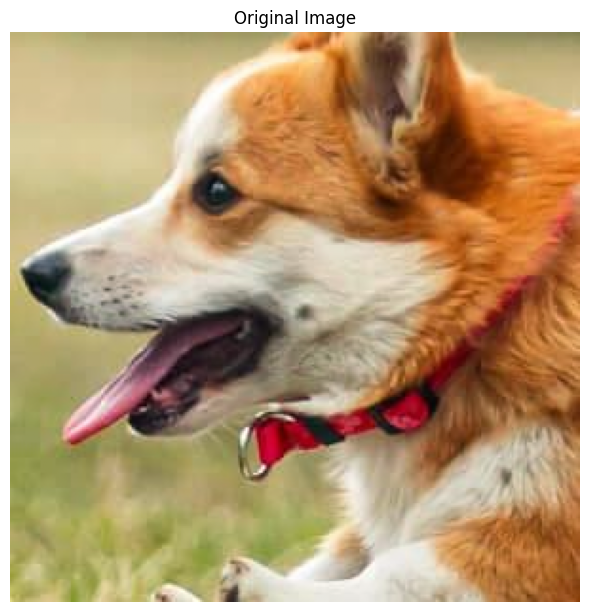

In [5]:
image = torchvision.io.read_image("/kaggle/input/imagesnew/sample_images/dogCropped.jpg")
image = image.to(device)
image = image.permute(1,2,0)
image_np = image.cpu().numpy()
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
image_np = scaler.fit_transform(image_np.reshape(-1, image_np.shape[-1])).reshape(image_np.shape)
image = torch.tensor(image_np).to(device)
plot_images([image], ["Original Image"])


#### Defining the Linear regressor Model

In [6]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


def create_coordinate_map(img: torch.Tensor, mask = None)-> tuple[torch.Tensor, torch.Tensor]:
    """
    img shape: (height, width, num_channels)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    height, width, num_channels = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1)

    # Reshape image for mapping
    Y = img.reshape(-1, num_channels)
    
    if mask is not None:
        mask = mask.flatten()
        X = X[mask]
        Y = Y[mask]   
    
    return X, Y

# function to create RFF features
def create_rff_features(X:torch.Tensor, num_features: int, sigma: float):
    """
    creates feature space using Radial basis function on Random fourier features on the tensor X  
    X (torch.Tensor): input tensor  
    num_features: number of features to generate  
    sigma: sigma to calculate gamma of RBF kernel   
    """
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=42)    # manually seeding to maintain reproducibility across function calls.
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


def train(net: nn.Module, lr: float, X:torch.Tensor, Y:torch.Tensor, epochs: int, verbose=True)->float:
    """
    net: torch.nn.Module  
    lr: float  
    X: torch.Tensor of shape (num_samples, 2)  
    Y: torch.Tensor of shape (num_samples, 3)  
    returns:  
    final MSE loss value after training
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    Y = Y.float()

    for epoch in range(epochs+1):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

#### Patching the Image

/opt/conda/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


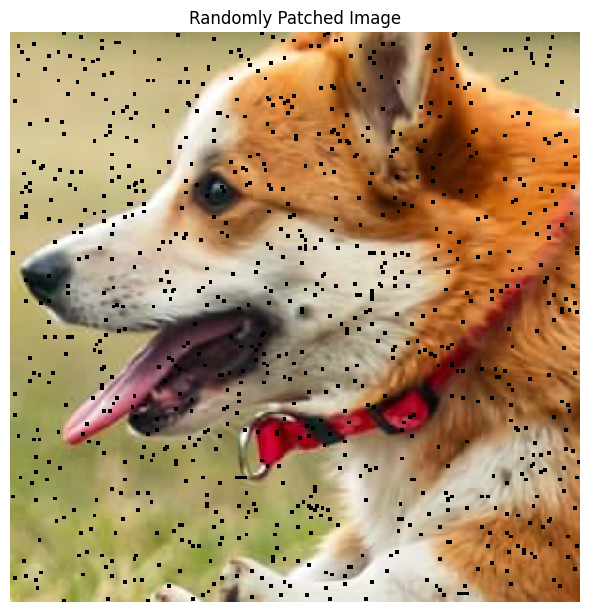

In [7]:
randomlyPatchedImage = image.clone().detach()
#mask = np.random.rand(*randomlyPatchedImage.shape[:2]) < 0.01  # 1% of the image will be masked
height, width = randomlyPatchedImage.shape[:2]
total_pixels = height * width

# Create an initially all-False mask
mask = np.zeros((height, width), dtype=bool)

# Randomly choose 900 unique pixel indices
random_indices = np.random.choice(total_pixels, size=900, replace=False)

# Set the mask for these indices to True
mask[np.unravel_index(random_indices, (height, width))] = True
randomlyPatchedImage[mask, : ] = torch.nan
plot_images([randomlyPatchedImage], ["Randomly Patched Image"])

#### Function for Reconstruction

In [10]:
def reconstruct(mask, patchedImage, num_rff: int):
    """
    X - X Feature space of original image
    X_img_shape - Shape of the original image
    Y - Y feature space of original image
    patched - Patched image
    num_rff - Number of random fourier features to generate
    """

    sigma = 0.008
    epochs = 1000
    lr = 0.01
    
    mask = ~mask
    #print(mask)
    
    X_available, Y_available = create_coordinate_map(patchedImage, mask)
    X_available_scaled = torch.tensor(preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_available), device=device).float()
    X_available_rff = create_rff_features(X_available_scaled, num_rff, sigma)
    
    print('Shape of RFF for availableImage: ', X_available_rff.shape)

    # Create a linear model
    rff_model = LinearModel(X_available_rff.shape[1], Y_available.shape[1])
    rff_model.to(device)

    # Train the model
    loss = train(rff_model, lr, X_available_rff, Y_available, epochs, verbose=True)

    height, width, num_channels = patchedImage.shape[0], patchedImage.shape[1], patchedImage.shape[2]
    
    w_coords = torch.arange(0, width, 1).repeat(height, 1)
    h_coords = torch.arange(0, height, 1).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor and create RFFs space
    X_coords = torch.stack([h_coords, w_coords], dim=1).float()
    # MinMaxScaler from -1 to 1
    X_coords_scaled = torch.tensor(preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_coords), device=device).float()

    X_coords_rff = create_rff_features(X_coords_scaled, num_rff, sigma)
    print('Shape of X_RFF for inference: ', X_coords_rff.shape)

    rff_model.eval()   

#     X_test, Y_test = create_coordinate_map(patchedImage)
#     X_test_scaled = torch.tensor(preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_test), device=device).float()

#     X_test_rff = create_rff_features(X_test_scaled, num_rff, sigma)
    with torch.inference_mode():
        #getting prediction
        Y_pred = rff_model(X_coords_rff)
        reconstructed_image = Y_pred.reshape(height, width, num_channels)

    plot_images([image,patchedImage, reconstructed_image], ["Original Image", "Patched Image", "Reconstructed Image"])
    
    mse = MeanSquaredError(device=device)
    psnr = PeakSignalNoiseRatio(device=device)
    mse.update(reconstructed_image.reshape(-1), image.reshape(-1))
    mse_val = mse.compute().item()
    psnr.update(reconstructed_image.reshape(-1), image.reshape(-1))
    psnr_val = psnr.compute().item()

    print(f"MSE: {mse_val:.6f}, PSNR: {psnr_val:.6f}")
    
    del X_available_rff
    del rff_model


Shape of RFF for availableImage:  torch.Size([89100, 15000])
Epoch 0 loss: 0.371950
Epoch 500 loss: 0.002105
Epoch 1000 loss: 0.000807
Shape of X_RFF for inference:  torch.Size([90000, 15000])


/opt/conda/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


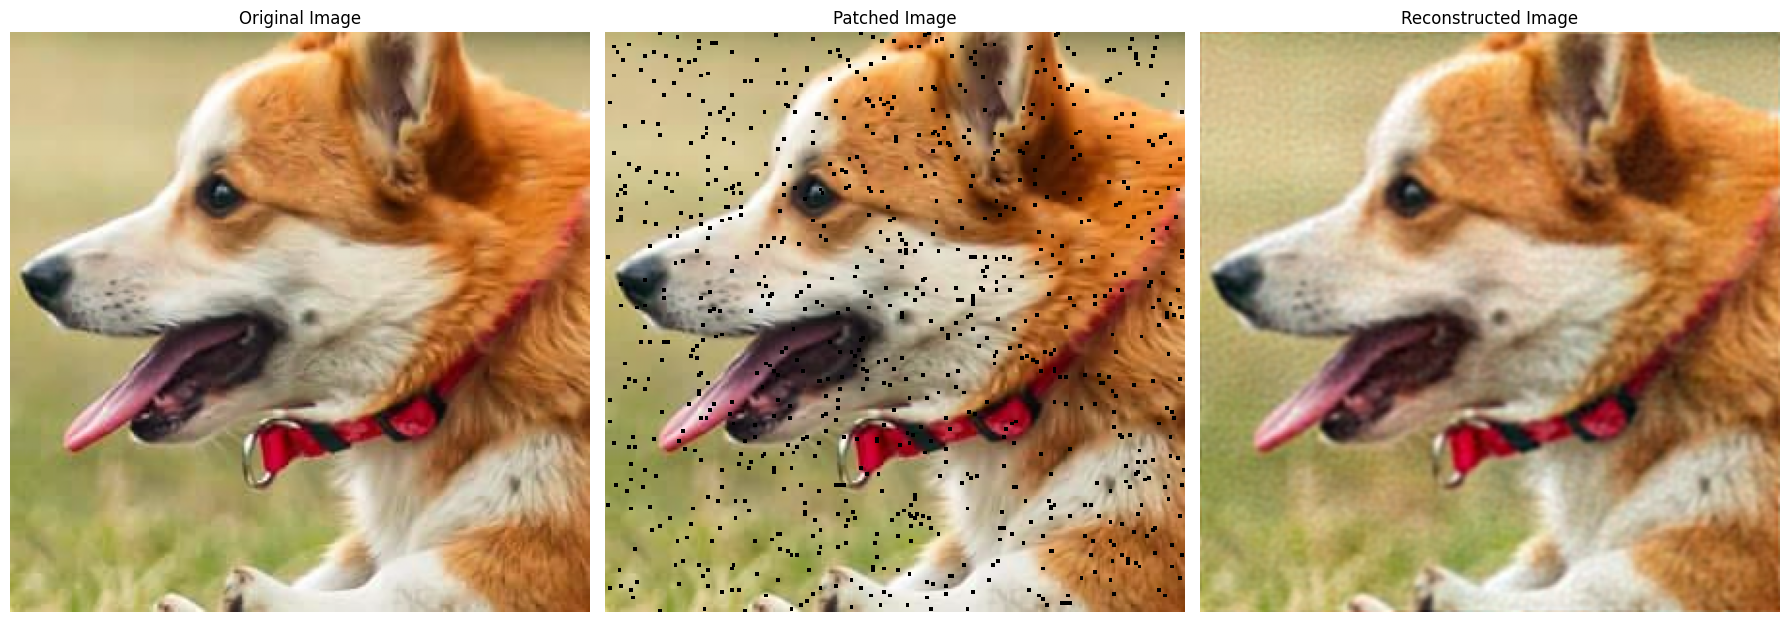

MSE: 0.000809, PSNR: 30.922642


In [11]:
reconstruct(mask, randomlyPatchedImage, 15000)

#### Results
As we can see the code using NMF takes less time and space for predicting the image, while also getting a higher value of PSNR i.e, `53.64 vs 30.92 db`. Therefore, Non negative Matrix Factorization is a better method in this case. 